## Table of Contents

<ol>
    <li>
        <a href="#Introduction">Introduction</a>
    </li>
    <li>
        <a href="#Gathering-the-data">Gathering-the-data</a>
    </li>
    <li>
        <a href="#Preparing-the-dataset">Preparing the dataset</a>
    </li>
    <li>
        <a href="#Code-generation-with-a-pipeline">Code generation with a pipeline</a>
    </li>
    <li>
        <a href="#Training-with-🤗-Accelerate">Training with 🤗 Accelerate</a>
    </li>
</ol>

## Introduction

Up until now, we’ve mostly been using pretrained models and fine-tuning them for new use cases by reusing the weights from pretraining. As we saw in [Chapter 1](https://huggingface.co/course/chapter1), this is commonly referred to as transfer learning, and it’s a very successful strategy for applying Transformer models to most real-world use cases where labeled data is sparse. In this chapter, we’ll take a different approach and train a completely new model from scratch. This is a good approach to take if you have a lot of data and it is very different from the pretraining data used for the available models. However, it also requires considerably more compute resources to pretrain a language model than just to fine-tune an existing one. Examples where it can make sense to train a new model include for datasets consisting of musical notes, molecular sequences such as DNA, or programming languages. The latter have recently gained traction thanks to tools such as TabNine and GitHub’s Copilot, powered by OpenAI’s Codex model, that can generate long sequences of code. This task of text generation is best addressed with auto-regressive or causal language models such as GPT-2.

In this section we will build a scaled-down version of a code generation model: we’ll focus on one-line completions instead of full functions or classes, using a subset of Python code. When working with data in Python you are in frequent contact with the Python data science stack, consisting of the matplotlib, seaborn, pandas, and scikit-learn libraries. When using those frameworks it’s common to need to look up specific commands, so it would be nice if we could use a model to complete these calls for us.

In [Chapter 6](https://huggingface.co/course/chapter6) we created an efficient tokenizer to process Python source code, but what we still need is a large-scale dataset to pretrain a model on. Here, we’ll apply our tokenizer to a corpus of Python code derived from GitHub repositories. We will then use the `Trainer API` and 🤗 Accelerate to train the model. Let’s get to it!

This is actually showcasing the model that was trained and uploaded to the Hub using the code shown in this section. You can find it here. Note that since there is some randomization happening in the text generation, you will probably get a slightly different result.

This is actually showcasing the model that was trained and uploaded to the Hub using the code shown in this section. You can find it [here](https://huggingface.co/huggingface-course/codeparrot-ds?text=plt.imshow%28). Note that since there is some randomization happening in the text generation, you will probably get a slightly different result.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
Tesla P40


##  Gathering the data

Python code is abundantly available from code repositories such as GitHub, which we can use to create a dataset by scraping for every Python repository. This was the approach taken in the [Transformers textbook](https://learning.oreilly.com/library/view/natural-language-processing/9781098136789/) to pretrain a large GPT-2 model. Using a GitHub dump of about 180 GB containing roughly 20 million Python files called `codeparrot`, the authors built a dataset that they then shared on the [Hugging Face Hub](https://huggingface.co/datasets/transformersbook/codeparrot).

However, training on the full corpus is time- and compute-consuming, and we only need the subset of the dataset concerned with the Python data science stack. So, let’s start by filtering the `codeparrot` dataset for all files that include any of the libraries in this stack. Because of the dataset’s size, we want to avoid downloading it; instead, we’ll use the streaming feature to filter it on the fly. To help us filter the code samples using the libraries we mentioned earlier, we’ll use the following function:

In [2]:
def any_keyword_in_string(string, keywords):
    for keyword in keywords:
        if keyword in string:
            return True
    return False

Let’s test it on two examples:

In [3]:
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
example_1 = "import numpy as np"
example_2 = "import pandas as pd"

print(
    any_keyword_in_string(example_1, filters), any_keyword_in_string(example_2, filters)
)

False True


We can use this to create a function that will stream the dataset and filter the elements we want:

In [4]:
from collections import defaultdict
from tqdm import tqdm
from datasets import Dataset


def filter_streaming_dataset(dataset, filters):
    filtered_dict = defaultdict(list)
    total = 0
    for sample in tqdm(iter(dataset)):
        total += 1
        if any_keyword_in_string(sample["content"], filters):
            for k, v in sample.items():
                filtered_dict[k].append(v)
    print(f"{len(filtered_dict['content'])/total:.2%} of data after filtering.")
    return Dataset.from_dict(filtered_dict)

Then we can simply apply this function to the streaming dataset:

```python
# This cell will take a very long time to execute, so you should skip it and go to
# the next one!
from datasets import load_dataset

split = "train"  # "valid"
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]

data = load_dataset(f"transformersbook/codeparrot-{split}", split=split, streaming=True)
filtered_data = filter_streaming_dataset(data, filters)
```

This leaves us with about 3% of the original dataset, which is still quite sizable — the resulting dataset is 6 GB and consists of 600,000 Python scripts!

Filtering the full dataset can take 2-3h depending on your machine and bandwidth. If you don’t want to go through this lengthy process yourself, we provide the filtered dataset on the Hub for you to download:

```python
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train,  # .shuffle().select(range(50000)),
        "valid": ds_valid,  # .shuffle().select(range(500))
    }
)

raw_datasets
```

Pretraining the language model will take a while. We suggest that you first run the training loop on a sample of the data by uncommenting the two partial lines above, and make sure that the training successfully completes and the models are stored. Nothing is more frustrating than a training run failing at the last step because you forgot to create a folder or because there’s a typo at the end of the training loop!

In [5]:
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train.shuffle().select(range(50000)),
        "valid": ds_valid.shuffle().select(range(500))
    }
)

raw_datasets

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 50000
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 500
    })
})

Let’s look at an example from the dataset. We’ll just show the first 200 characters of each field:

In [6]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

REPO_NAME: CharlesGulian/Deconv
PATH: sex_stats.py
COPIES: 1
SIZE: 8624
CONTENT: # -*- coding: utf-8 -*-
"""
Created on Wed Jun 29 20:31:36 2016
@author: charlesgulian
"""
# Library of statistics functions for photometric statistics and data analysis

import os
os.chdir('/Users/an
LICENSE: gpl-3.0


We can see that the content field contains the code that we want our model to train on. Now that we have a dataset, we need to prepare the texts so they’re in a format suitable for pretraining.

##  Preparing the dataset

The first step will be to tokenize the data, so we can use it for training. Since our goal is to mainly autocomplete short function calls, we can keep the context size relatively small. This has the benefit that we can train the model much faster and it requires significantly less memory. If it is important for your application to have more context (for example, if you want the model to write unit tests based on a file with the function definition), make sure you increase that number, but also keep in mind that this comes with a greater GPU memory footprint. For now, let’s fix the context size at 128 tokens, as opposed to the 1,024 or 2,048 used in GPT-2 or GPT-3, respectively.

Most documents contain many more than 128 tokens, so simply truncating the inputs to the maximum length would eliminate a large fraction of our dataset. Instead, we’ll use the `return_overflowing_tokens` option to tokenize the whole input and split it into several chunks, as we did in [Chapter 6](https://huggingface.co/course/chapter6/4). We’ll also use the `return_length` option to return the length of each created chunk automatically. Often the last chunk will be smaller than the context size, and we’ll get rid of these pieces to avoid padding issues; we don’t really need them as we have plenty of data anyway.

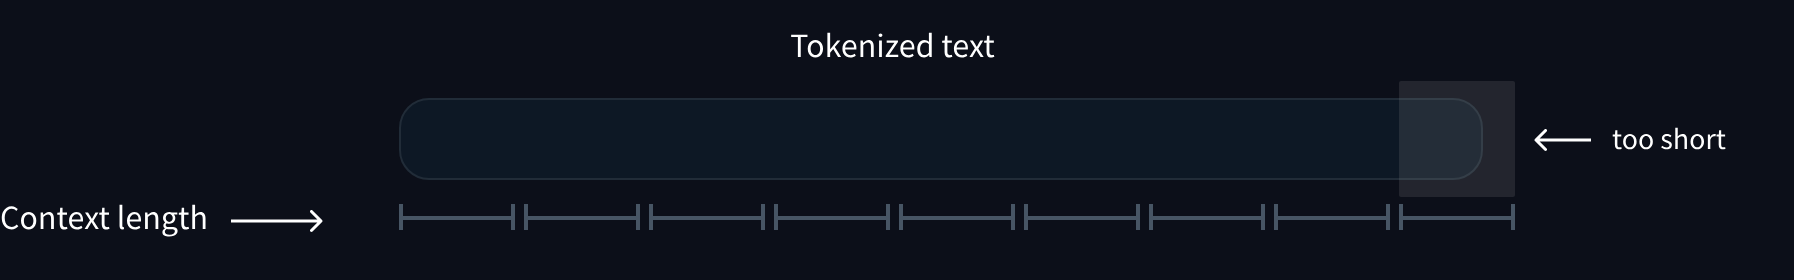

Let’s see exactly how this works by looking at the first two examples:

In [7]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 115
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 72, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 60]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


We can see that we get 34 segments in total from those two examples. Looking at the chunk lengths, we can see that the chunks at the ends of both documents have less than 128 tokens (117 and 41, respectively). These represent just a small fraction of the total chunks that we have, so we can safely throw them away. With the overflow_to_sample_mapping field, we can also reconstruct which chunks belonged to which input samples.

With this operation we’re using a handy feature of the `Dataset.map()` function in 🤗 Datasets, which is that it does not require one-to-one maps; as we saw in [section 3](https://huggingface.co/course/chapter7/3), we can create batches with more or fewer elements than the input batch. This is useful when doing operations like data augmentation or data filtering that change the number of elements. In our case, when tokenizing each element into chunks of the specified context size, we create many samples from each document. We just need to make sure to delete the existing columns, since they have a conflicting size. If we wanted to keep them, we could repeat them appropriately and return them within the `Dataset.map()` call:

In [8]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 1388829
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 15859
    })
})

We now have 16.7 million examples with 128 tokens each, which corresponds to about 2.1 billion tokens in total. For reference, OpenAI’s GPT-3 and Codex models are trained on 300 and 100 billion tokens, respectively, where the Codex models are initialized from the GPT-3 checkpoints. Our goal in this section is not to compete with these models, which can generate long, coherent texts, but to create a scaled-down version providing a quick autocomplete function for data scientists.

Now that we have the dataset ready, let’s set up the model!

✏️ Try it out! Getting rid of all the chunks that are smaller than the context size wasn’t a big issue here because we’re using small context windows. As you increase the context size (or if you have a corpus of short documents), the fraction of chunks that are thrown away will also grow. A more efficient way to prepare the data is to join all the tokenized samples in a batch with an eos_token_id token in between, and then perform the chunking on the concatenated sequences. As an exercise, modify the tokenize() function to make use of that approach. Note that you’ll want to set truncation=False and remove the other arguments from the tokenizer to get the full sequence of token IDs.

###  Initializing a new model

Our first step is to freshly initialize a GPT-2 model. We’ll use the same configuration for our model as for the small GPT-2 model, so we load the pretrained configuration, make sure that the tokenizer size matches the model vocabulary size and pass the bos and eos (beginning and end of sequence) token IDs:

In [9]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

With that configuration, we can load a new model. Note that this is the first time we don’t use the from_pretrained() function, since we’re actually initializing a model ourself:

In [10]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


Our model has 124M parameters that we’ll have to tune. Before we can start training, we need to set up a data collator that will take care of creating the batches. We can use the `DataCollatorForLanguageModeling` collator, which is designed specifically for language modeling (as the name subtly suggests). Besides stacking and padding batches, it also takes care of creating the language model labels — in causal language modeling the inputs serve as labels too (just shifted by one element), and this data collator creates them on the fly during training so we don’t need to duplicate the `input_ids`.

Note that `DataCollatorForLanguageModeling` supports both masked language modeling (MLM) and causal language modeling (CLM). By default it prepares data for MLM, but we can switch to CLM by setting the argument `mlm=False`:

In [11]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

Let’s have a look at an example:

In [12]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


We can see that the examples have been stacked and all the tensors have the same shape.

⚠️ Shifting the inputs and labels to align them happens inside the model, so the data collator just copies the inputs to create the labels.

Now we have everything in place to actually train our model — that wasn’t so much work after all! Before we start training we should log in to Hugging Face. If you’re working in a notebook, you can do so with the following utility function:

```python
from huggingface_hub import notebook_login

notebook_login()
```

This will display a widget where you can enter your Hugging Face login credentials.

If you aren’t working in a notebook, just type the following line in your terminal: `huggingface-cli login`

All that’s left to do is configure the training arguments and fire up the Trainer. We’ll use a cosine learning rate schedule with some warmup and an effective batch size of 256 (`per_device_train_batch_size` * `gradient_accumulation_steps`). Gradient accumulation is used when a single batch does not fit into memory, and incrementally builds up the gradient through several forward/backward passes. We’ll see this in action when we create the training loop with 🤗 Accelerate.

In [13]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="codeparrot-ds",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
trainer.evaluate()

{'eval_loss': 10.937533378601074,
 'eval_model_preparation_time': 0.005,
 'eval_runtime': 138.1641,
 'eval_samples_per_second': 114.784,
 'eval_steps_per_second': 3.59}

Now we can just start the `Trainer` and wait for training to finish. Depending on whether you run it on the full or a subset of the training set this will take 20 or 2 hours, respectively, so grab a few coffees and a good book to read!

In [16]:
# 10 hours
# trainer.train()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


After training completes, we can push the model and tokenizer to the Hub: `trainer.push_to_hub()`

✏️ Try it out! It only took us about 30 lines of code in addition to the TrainingArguments to get from raw texts to training GPT-2. Try it out with your own dataset and see if you can get good results!



💡 If you have access to a machine with multiple GPUs, try to run the code there. The Trainer automatically manages multiple machines, and this can speed up training tremendously.


##  Code generation with a pipeline

Now is the moment of truth: let’s see how well the trained model actually works! We can see in the logs that the loss went down steadily, but to put the model to the test let’s take a look at how well it works on some prompts. To do that we’ll wrap the model in a text generation pipeline, and we’ll put it on the GPU for fast generations if there is one available:

In [17]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline(
    "text-generation", model="huggingface-course/codeparrot-ds", device=device
)

config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/789k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/448k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let’s start with the simple task of creating a scatter plot:

In [18]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
fig = plt.figure()
ax = fig.add_


 Since the number of generated tokens is limited. Let’s see if we can do something a bit more complex and have the model help us use the groupby operation:

In [57]:
txt = """\
# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession
def calc_stats(


Not bad; that’s the right way to do it. Finally, let’s see if we can also use it for scikit-learn and set up a Random Forest model:

In [58]:
txt = """
# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:
est_1 = RandomForestRegressor(n_estimators = 300, random


Looking at these few examples, it seems that the model has learned some of the syntax of the Python data science stack (of course, we would need to evaluate it more thoroughly before deploying the model in the real world). Sometimes it requires more customization of the model training to achieve the necessary performance for a given use case, however. For example, what if we would like to dynamically update the batch size or have a conditional training loop that skips bad examples on the fly? One option would be to subclass the Trainer and add the necessary changes, but sometimes it’s simpler to write the training loop from scratch. That’s where 🤗 Accelerate comes in.

## Training with 🤗 Accelerate

Since we are mainly interested in sensible autocompletion for the the data science libraries, it makes sense to give more weight to training samples that make more use of these libraries. We can easily identify these examples through the use of keywords such as `plt`, `pd`, `sk`, `fit`, and `predict`, which are the most frequent import names for `matplotlib.pyplot`, `pandas`, and `sklearn` as well as the fit/predict pattern of the latter. If these are each represented as a single token, we can easily check if they occur in the input sequence. Tokens can have a whitespace prefix, so we’ll also check for those versions in the tokenizer vocabulary. To verify that it works, we’ll add one test token which should be split into multiple tokens:

In [59]:
keytoken_ids = []
for keyword in [
    "plt",
    "pd",
    "sk",
    "fit",
    "predict",
    " plt",
    " pd",
    " sk",
    " fit",
    " predict",
    "testtest",
]:
    ids = tokenizer([keyword]).input_ids[0]
    if len(ids) == 1:
        keytoken_ids.append(ids[0])
    else:
        print(f"Keyword has not single token: {keyword}")

Keyword has not single token: testtest


Great, that seems to work nicely! We can now write a custom loss function that takes the input sequence, the logits, and the key tokens we just selected as inputs. First we need to align the logits and inputs: the input sequence shifted by one to the right forms the labels, since the next token is the label for the current token. We can achieve this by starting the labels from the second token of the input sequence, since the model does not make a prediction for the first token anyway. Then we cut off the last logit, as we don’t have a label for the token that follows the full input sequence. With that we can compute the loss per sample and count the occurrences of all keywords in each sample. Finally, we calculate the weighted average over all samples using the occurrences as weights. Since we don’t want to throw away all the samples that have no keywords, we add 1 to the weights:

In [60]:
from torch.nn import CrossEntropyLoss
import torch


def keytoken_weighted_loss(inputs, logits, keytoken_ids, alpha=1.0):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)
    # Calculate and scale weighting
    weights = torch.stack([(inputs == kt).float() for kt in keytoken_ids]).sum(
        axis=[0, 2]
    )
    weights = alpha * (1.0 + weights)
    # Calculate weighted average
    weighted_loss = (loss_per_sample * weights).mean()
    return weighted_loss

Before we can start training with this awesome new loss function, we need to prepare a few things:

- We need dataloaders to load the data in batches.

- We need to set up weight decay parameters.

- From time to time we want to evaluate, so it makes sense to wrap the evaluation code in a function.

Let’s start with the dataloaders. We only need to set the dataset’s format to "torch", and then we can pass it to a PyTorch DataLoader with the appropriate batch size:

In [62]:
from torch.utils.data.dataloader import DataLoader

tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
eval_dataloader = DataLoader(tokenized_datasets["valid"], batch_size=32)

Next, we group the parameters so that the optimizer knows which ones will get an additional weight decay. Usually, all bias and LayerNorm weights terms are exempt from this; here’s how we can do this:

In [63]:
weight_decay = 0.1


def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weight_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]

Since we want to evaluate the model regularly on the validation set during training, let’s write a function for that as well. It just runs through the evaluation dataloader and gathers all the losses across processes:

```python
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])

        losses.append(accelerator.gather(outputs.loss))
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float("inf")
    return loss.item(), perplexity.item()
```

In [71]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            # Compute model outputs and loss
            outputs = model(batch["input_ids"], labels=batch["input_ids"])
        
        # Ensure loss is at least 1-dimensional before appending
        losses.append(accelerator.gather(outputs.loss.unsqueeze(0)))
    
    # Concatenate gathered losses and compute mean
    loss = torch.mean(torch.cat(losses, dim=0))
    
    try:
        # Compute perplexity
        perplexity = torch.exp(loss)
    except OverflowError:
        # Handle overflow case for perplexity
        perplexity = float("inf")
    
    return loss.item(), perplexity.item()


With the `evaluate()` function we can report loss and [perplexity](https://huggingface.co/course/chapter7/3) at regular intervals. Next, we redefine our model to make sure we train from scratch again:

In [65]:
model = GPT2LMHeadModel(config)

We can then define our optimizer, using the function from before to split the parameters for weight decay:

In [66]:
from torch.optim import AdamW

optimizer = AdamW(get_grouped_params(model), lr=5e-4)

Now let’s prepare the model, optimizer, and dataloaders so we can start training:

In [68]:
from accelerate import Accelerator

# Specify 'fp16' using the 'mixed_precision' argument
accelerator = Accelerator(mixed_precision="fp16")

# Prepare the model, optimizer, and data loaders
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)


Now that we have sent our train_dataloader to `accelerator.prepare()`, we can use its length to compute the number of training steps. Remember that we should always do this after preparing the dataloader, as that method will change its length. We use a classic linear schedule from the learning rate to 0:

In [69]:
from transformers import get_scheduler

num_train_epochs = 1
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=1_000,
    num_training_steps=num_training_steps,
)

Lastly, to push our model to the Hub, we will need to create a `Repository` object in a working folder. First log in to the Hugging Face Hub, if you aren’t logged in already. We’ll determine the repository name from the model ID we want to give our model (feel free to replace the repo_name with your own choice; it just needs to contain your username, which is what the function `get_full_repo_name()` does):

```python
from huggingface_hub import Repository, get_full_repo_name

model_name = "codeparrot-ds-accelerate"
repo_name = get_full_repo_name(model_name)

```

Then we can clone that repository in a local folder. If it already exists, this local folder should be an existing clone of the repository we are working with:

```
output_dir = "codeparrot-ds-accelerate"
repo = Repository(output_dir, clone_from=repo_name)
```

We can now upload anything we save in `output_dir` by calling the `repo.push_to_hub()` method. This will help us upload the intermediate models at the end of each epoch.

Before we train, let’s run a quick test to see if the evaluation function works properly:

In [72]:
evaluate()

(10.987804412841797, 59148.375)

Those are very high values for loss and perplexity, but that’s not surprising as we haven’t trained the model yet. With that, we have everything prepared to write the core part of the training script: the training loop. In the training loop we iterate over the dataloader and pass the batches to the model. With the logits, we can then evaluate our custom loss function. We scale the loss by the number of gradient accumulation steps so as not to create larger losses when aggregating more steps. Before we optimize, we also clip the gradients for better convergence. Finally, every few steps we evaluate the model on the evaluation set with our new `evaluate()` function:

In [ ]:
from tqdm.notebook import tqdm  # Importing tqdm for progress visualization in Jupyter Notebooks

# Gradient accumulation allows for effectively larger batch sizes by accumulating gradients over multiple steps
gradient_accumulation_steps = 8  
# Number of steps between evaluation runs
eval_steps = 5_000  

model.train()  # Set the model to training mode
completed_steps = 0  # Initialize a counter to track completed optimization steps

# Loop over the number of training epochs
for epoch in range(num_train_epochs):
    # Loop through the training dataloader, showing progress with tqdm
    for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=num_training_steps
    ):
        # Forward pass: compute logits from the model
        logits = model(batch["input_ids"]).logits  
        # Compute the custom loss function, weighted by key tokens
        loss = keytoken_weighted_loss(batch["input_ids"], logits, keytoken_ids)  
        
        # Print progress every 100 steps
        if step % 100 == 0:
            accelerator.print(
                {
                    "samples": step * samples_per_step,  # Number of samples processed
                    "steps": completed_steps,  # Completed optimization steps
                    "loss/train": loss.item() * gradient_accumulation_steps,  # Rescaled loss
                }
            )
        
        # Normalize the loss for gradient accumulation
        loss = loss / gradient_accumulation_steps  
        # Backpropagate the loss
        accelerator.backward(loss)  

        # Perform optimization step after accumulating enough gradients
        if step % gradient_accumulation_steps == 0:
            # Gradient clipping to prevent exploding gradients
            accelerator.clip_grad_norm_(model.parameters(), 1.0)  
            # Update model parameters
            optimizer.step()  
            # Update learning rate scheduler
            lr_scheduler.step()  
            # Reset optimizer gradients
            optimizer.zero_grad()  
            # Increment the counter for completed optimization steps
            completed_steps += 1  

        # Evaluate and save model periodically
        if (step % (eval_steps * gradient_accumulation_steps)) == 0:
            eval_loss, perplexity = evaluate()  # Evaluate the model and compute metrics
            # Log evaluation metrics
            accelerator.print({"loss/eval": eval_loss, "perplexity": perplexity})  
            model.train()  # Return model to training mode after evaluation
            
            # Ensure all processes synchronize before saving the model
            accelerator.wait_for_everyone()  
            # Save the model (unwrapped for saving without parallelization metadata)
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
            
            # Save tokenizer and push progress to repository if this is the main process
            if accelerator.is_main_process:
                tokenizer.save_pretrained(output_dir)
                repo.push_to_hub(
                    commit_message=f"Training in progress step {step}", blocking=False
                )

And that’s it — you now have your own custom training loop for causal language models such as GPT-2 that you can further customize to your needs.



✏️ Try it out! Either create your own custom loss function tailored to your use case, or add another custom step into the training loop.

✏️ Try it out! When running long training experiments it’s a good idea to log important metrics using tools such as TensorBoard or Weights & Biases. Add proper logging to the training loop so you can always check how the training is going.